In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

In [73]:
if os.getcwd() != "/home/smoate/code/ml-bootstrap-example/":
    os.chdir("/home/smoate/code/ml-bootstrap-example/")

cwd = os.getcwd()
print(cwd)

/home/smoate/code/ml-bootstrap-example


In [74]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, data, labels):
        self.labels = torch.load("data/processed/" + labels)
        self.data = torch.load("data/processed/" + data) 

  def __len__(self):
        return len(self.data)

  def __getitem__(self, index):
        X = self.data[index]
        y = self.labels[index]
        return X, y

In [75]:
def load_data():
    print("Loading the processed training data...")
    train_data = Dataset("train_x_processed.pt", "train_y_processed.pt")
    print("Generating data and creating batches for training...")
    train_loader = torch.utils.data.DataLoader(
                      train_data,
                      batch_size=64, 
                      shuffle=True)

    print("Loading the processed validation data...")
    validation_data = Dataset("valid_x_processed.pt", "valid_y_processed.pt")
    print("Generating data and creating batches for validation...")
    validation_loader = torch.utils.data.DataLoader(
                      validation_data,
                      batch_size=100, 
                      shuffle=True)
    return train_loader, validation_loader

In [76]:
train_loader, validation_loader = load_data()

Loading the processed training data...
Generating data and creating batches for training...
Loading the processed validation data...
Generating data and creating batches for validation...


In [77]:
examples = enumerate(validation_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [78]:
example_data.shape

torch.Size([100, 1, 28, 28])

In [79]:
example_targets.shape

torch.Size([100])

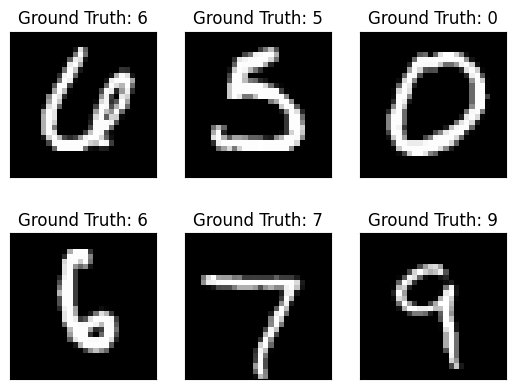

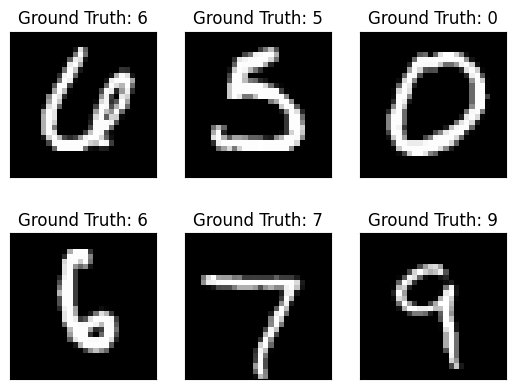

In [80]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [81]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim = 1)

In [82]:
learning_rate = 0.01
momentum = 0.5

network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [83]:
n_epochs = 5
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [84]:
log_interval = 10

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'models/model.pth')
      torch.save(optimizer.state_dict(), 'models/optimizer.pth')


In [85]:
def validate():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in validation_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(validation_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(validation_loader.dataset),
    100. * correct / len(validation_loader.dataset)))

In [86]:
validate()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  validate()


Test set: Avg. loss: 18.7092, Accuracy: 779/8400 (9%)

Train Epoch: 1 [0/33600 (0%)]	Loss: 34.211758
Train Epoch: 1 [640/33600 (2%)]	Loss: 2.316935
Train Epoch: 1 [1280/33600 (4%)]	Loss: 2.296868
Train Epoch: 1 [1920/33600 (6%)]	Loss: 2.182529
Train Epoch: 1 [2560/33600 (8%)]	Loss: 2.177657
Train Epoch: 1 [3200/33600 (10%)]	Loss: 2.087338
Train Epoch: 1 [3840/33600 (11%)]	Loss: 2.132449
Train Epoch: 1 [4480/33600 (13%)]	Loss: 1.916838
Train Epoch: 1 [5120/33600 (15%)]	Loss: 1.924090
Train Epoch: 1 [5760/33600 (17%)]	Loss: 1.852071
Train Epoch: 1 [6400/33600 (19%)]	Loss: 1.726726
Train Epoch: 1 [7040/33600 (21%)]	Loss: 1.645922
Train Epoch: 1 [7680/33600 (23%)]	Loss: 1.496487
Train Epoch: 1 [8320/33600 (25%)]	Loss: 1.475263
Train Epoch: 1 [8960/33600 (27%)]	Loss: 1.523093
Train Epoch: 1 [9600/33600 (29%)]	Loss: 1.278644
Train Epoch: 1 [10240/33600 (30%)]	Loss: 1.385848
Train Epoch: 1 [10880/33600 (32%)]	Loss: 1.370173
Train Epoch: 1 [11520/33600 (34%)]	Loss: 1.214763
Train Epoch: 1 [12


Test set: Avg. loss: 0.1112, Accuracy: 8113/8400 (97%)



/home/smoate/.cache/pypoetry/virtualenvs/app-28m1ZLG7-py3.10/lib/python3.10/site-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


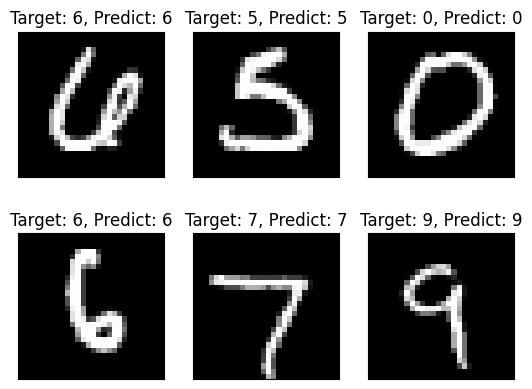

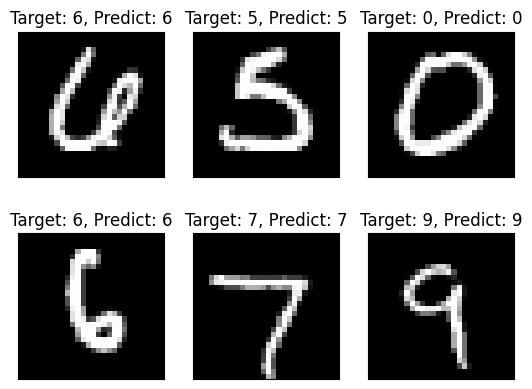

In [88]:
import matplotlib.pyplot as plt

validate()
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  output = network(example_data[i])
  pred = output.data.max(1, keepdim=True)[1]
  plt.title("Target: {}, Predict: {}".format(example_targets[i], pred.item()))
  plt.xticks([])
  plt.yticks([])
fig